In [10]:
import random as rd
import matplotlib.pyplot as plt
import numpy as np
import numbers
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from numpy import linspace, zeros
from csaps import CubicSmoothingSpline

def logistic_stimuli(x0,dt,T,s,r,A,t0=0,stimuli=None,noise_var=0,return_stimuli_bool=False):

    f = lambda u, t, r: r*(1 - u/A)*u
    f_s = lambda u, t, r, s: (r+s)*(1 - u/A)*u

    N_t = int(round(float(T)/dt))
    u = zeros(N_t+1)
    t = linspace(0, N_t*dt, len(u))
    t = t + t0

    if stimuli == False:
        stimuli = [False]*len(u)
    if stimuli == True:
        stimuli = [True]*len(u)
    if type(stimuli) == list:
        if len(stimuli) == 1:
            index = min(range(len(t)), key=lambda i: abs(t[i]-stimuli[0]))
            stimuli = [False]*len(u)
            stimuli[index] = True
        elif len(stimuli) == 2:
            index_min = min(range(len(t)), key=lambda i: abs(t[i]-stimuli[0]))
            if stimuli[1] == None:
                index_max = len(u)
            else:
                index_max = min(range(len(t)), key=lambda i: abs(t[i]-stimuli[1]))
            stimuli = [False]*len(u)
            stimuli[index_min:index_max+1] = [True]*(index_max-index_min)

    if isinstance(r, numbers.Number):
        r = [r]*len(u)

    if isinstance(s, numbers.Number):
        s = [s]*len(u)
    

    u, t, stimuli_applied = ode_FE(f=f,f_s=f_s,x0=x0,dt=dt,u=u,t=t,r=r,s=s,N_t=N_t,stimuli=stimuli)

    noise = np.random.normal(0,noise_var,len(u))
    u = u + noise
    
    if return_stimuli_bool:
        return u,t, stimuli_applied,stimuli
    else:
        return u,t, stimuli_applied

def ode_FE(f,f_s,x0,dt,u,t,r,s,N_t,stimuli):
    #print("n","t","dxdt","r","s","apply stimuly")
    u[0] = x0
    stimuli_applied = []
    for n in range(N_t):
        if stimuli[n]:
            u[n+1] = u[n] + dt*f_s(u[n], t[n], r[n],s[n])
            stimuli_applied.append(r[n] + s[n])
        else:
            u[n+1] = u[n] + dt*f(u[n], t[n], r[n])
            stimuli_applied.append(r[n])
        
        #print(f_s(u[n], t[n], r[n],s[n]))
        #print(n,round(u[n+1]-u[n],5),r[n],s[n],stimuli[n],t[n])
        #print(n,t[n],round(u[n+1]-u[n],5),r[n])

    return u, t, stimuli_applied

PYTHON_PATH = "/Users/rb4174/Documents/projects/brain_dev_primates/altricial_brain_vocal_learning"

In [11]:
SPECIES = "Marmoset"
COLOR = "orange"

df_events = pd.read_excel("{0}/data/developmental_stages_events.xlsx".format(PYTHON_PATH),index_col=False)
df_events = df_events[df_events.specie == SPECIES]
gestation_weeks = df_events[df_events.event == "gestation"]["avg_wkspc"].values[0]
gestation_weeks_sd = df_events[df_events.event == "gestation"]["sd_(days)"].values[0]/7


In [12]:
dt = 1/7 #day
T = 60 #number of weeks
A = 1
N_t = int(round(float(T)/dt))
u = zeros(N_t+1)

t_dev = linspace(0, N_t*dt, len(u))
t = linspace(0, N_t*dt, len(u))
t0 = gestation_weeks
t = t + t0

num_steps = len(u)

noise_var = 0.01

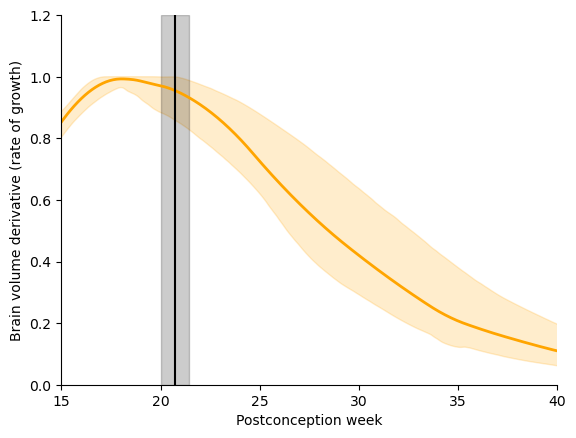

In [13]:
# Taking the marmoset curve as reference to create the altricial and precocial curves

df_fits = pd.read_pickle("{0}/data/derivatives_with_error.pkl".format(PYTHON_PATH)) 
df_fits = df_fits[df_fits.specie == SPECIES]

fig, ax = plt.subplots()

x_fit = df_fits["x_dydx"].values[0]
y_fit = df_fits["y_dydx"].values[0]
y_error_min = df_fits["y_dydx_low_95Percentil"].values[0]
y_error_max = df_fits["y_dydx_max_95Percentil"].values[0]

ax.plot(x_fit,y_fit, '-', color = COLOR,linewidth = 2)
ax.fill_between(x_fit, y_error_min, y_error_max, color=COLOR, alpha=0.2)

ax.axvline(x = gestation_weeks, color = "black",linestyle = '-',label="birth")
ax.axvspan(gestation_weeks - gestation_weeks_sd, gestation_weeks + gestation_weeks_sd, alpha=0.2, color='black')



plt.xlim(15, 40)
plt.ylim(0,1.2)
sns.despine()
plt.ylabel('Brain volume derivative (rate of growth)')
plt.xlabel('Postconception week')
plt.show()

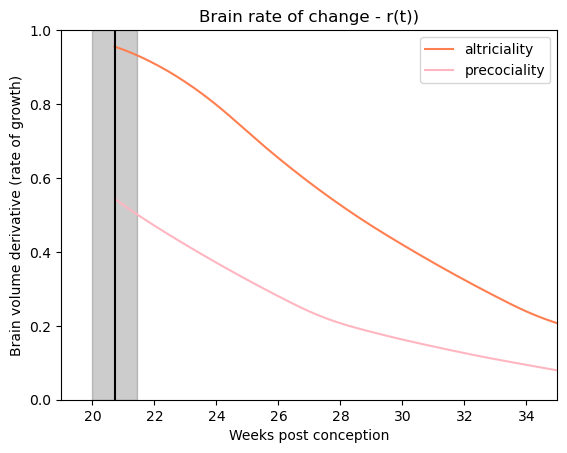

In [14]:
df_fit = pd.DataFrame({"x_fit":x_fit,"y_fit":y_fit})

#Creating the altricial curve
s = CubicSmoothingSpline(df_fit["x_fit"] - gestation_weeks, df_fit["y_fit"], normalizedsmooth=True).spline
dxdt = s(t_dev)
brain_plasticity_altricial = dxdt
plt.plot(t,brain_plasticity_altricial, color='coral',label = "altriciality")

#Creating the precocial curve curve
s = CubicSmoothingSpline(df_fit["x_fit"] - gestation_weeks - 7, df_fit["y_fit"], normalizedsmooth=True).spline
dxdt = s(t_dev)
brain_plasticity_precocial = dxdt
plt.plot(t,brain_plasticity_precocial, color='lightpink',label = "precociality")

plt.axvline(x = gestation_weeks, color = "black",linestyle = '-')
plt.axvspan(gestation_weeks - gestation_weeks_sd, gestation_weeks + gestation_weeks_sd, alpha=0.2, color='black')
plt.title("Brain rate of change - r(t))")
plt.ylabel('Brain volume derivative (rate of growth)')
plt.xlabel('Weeks post conception')
plt.legend()
plt.xlim(19,35)
plt.ylim(0,1)
plt.savefig("{0}/figs/3B.pdf".format(PYTHON_PATH),dpi = 800)


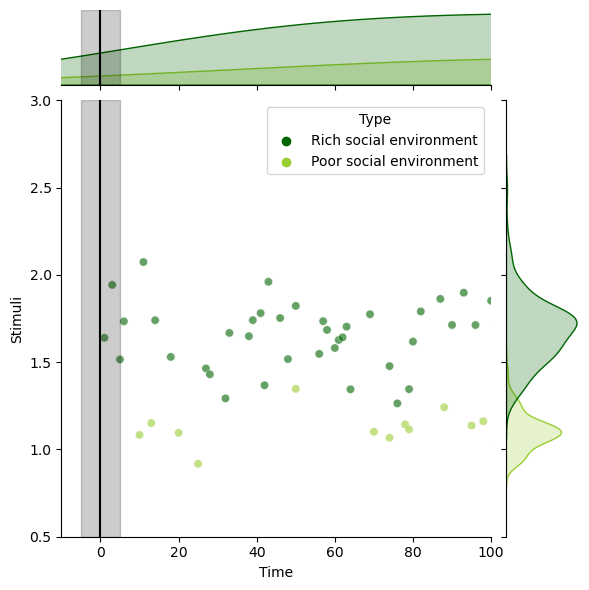

In [15]:
np.random.seed(5)
# Generate random stimulus values with probability 0.5
stimulus_high_contingency_presence = np.random.choice([0, 1], size=num_steps, p=[0.6, 0.4])

seed_low = 15 #10
np.random.seed(seed_low)
stimulus_low_contingency_presence = np.random.choice([0, 1], size=num_steps, p=[0.85, 0.15])
time = np.arange(num_steps)
np.random.seed(2)
mu, sigma = 0.5, 0.1 # mean and standard deviation
stimulus_high_contingency = np.random.lognormal(mu, sigma, num_steps)
np.random.seed(seed_low)
mu, sigma = 0.1, 0.1 # mean and standard deviation
stimulus_low_contingency = np.random.lognormal(mu, sigma, num_steps)
final_low = stimulus_low_contingency*stimulus_low_contingency_presence
final_high = stimulus_high_contingency*stimulus_high_contingency_presence


visualize_sti = {"Stimuli":[],"Time":[],"Type":[],"Frequency":[]}
visualize_sti["Stimuli"].extend(final_high)
visualize_sti["Time"].extend(time)
visualize_sti["Type"].extend(["Rich social environment"]*len(time))
visualize_sti["Frequency"].extend(stimulus_high_contingency_presence)

visualize_sti["Stimuli"].extend(final_low)
visualize_sti["Time"].extend(time)
visualize_sti["Type"].extend(["Poor social environment"]*len(time))
visualize_sti["Frequency"].extend(stimulus_low_contingency_presence)

visualize_sti = pd.DataFrame(visualize_sti)

visualize_sti = visualize_sti[visualize_sti.Stimuli != 0]
g = sns.jointplot(data=visualize_sti, x="Time", y="Stimuli", hue="Type",palette=["darkgreen","yellowgreen"],legend = True, alpha = 0.6)
for ax in (g.ax_joint, g.ax_marg_x):
    ax.axvline(x = 0, color = "black",linestyle = '-')
    ax.axvspan(0 - gestation_weeks_sd/dt, 0 + gestation_weeks_sd/dt, alpha=0.2, color='black')


#plt.title("Social stimulus - s(t))")
g.ax_marg_x.set_xlim(-10,(35 - gestation_weeks)*7)#400*35/60
g.ax_marg_y.set_ylim(0.5,3)
g.savefig("{0}/figs/3C.pdf".format(PYTHON_PATH),dpi = 800)



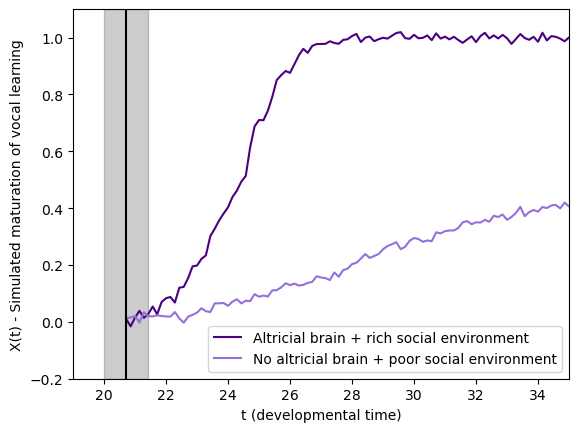

In [16]:
control_stimuli = 0
end_stimuli = 3

x0 = 0.01
x1 = gestation_weeks
x2 = 30
stimuli = [x1,x2]


r = brain_plasticity_altricial
s = final_high
label = "Altricial brain + rich social environment"
color = 'indigo'
u, t ,ri = logistic_stimuli(x0,dt,T,s,r,A,t0 = t0,stimuli=stimuli,noise_var=noise_var)
plt.plot(t, u, color,label = label)

r = brain_plasticity_precocial
s = final_low
label = "No altricial brain + poor social environment"
color = 'mediumpurple'
u, t ,ri = logistic_stimuli(x0,dt,T,s,r,A,t0 = t0,stimuli=stimuli,noise_var=noise_var)
plt.plot(t, u, color,label = label)

plt.axvline(x = gestation_weeks, color = "black",linestyle = '-')
plt.axvspan(gestation_weeks - gestation_weeks_sd, gestation_weeks + gestation_weeks_sd, alpha=0.2, color='black')
#plt.plot(t,brain_plasticity_altricial, color='orange')

plt.legend(loc = "lower right")
plt.xlim(19,35)
plt.ylim(-0.2,1.1)
plt.xlabel('t (developmental time)'); plt.ylabel('X(t) - Simulated maturation of vocal learning')
plt.savefig("{0}/figs/3D.pdf".format(PYTHON_PATH),dpi = 800)
